In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, losses, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import keras
from keras.saving import register_keras_serializable

2025-05-22 21:55:38.356789: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 21:55:38.367129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747940138.379562    9497 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747940138.383286    9497 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747940138.392573    9497 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
input_dim = (32, 32, 3)
latent_dim = 32

@keras.saving.register_keras_serializable()
class Sampling(layers.Layer):

    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

@keras.saving.register_keras_serializable()
class VAE(Model):
    def compile(self, **kwargs):
        super().compile(**kwargs, loss=None)

    def __init__(self, input_dim=input_dim, latent_dim=latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.beta = 1.0
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        
        encoder_inputs = layers.Input(shape=self.input_dim) # 32
        x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation='relu')(encoder_inputs) # 16
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation='relu')(encoder_inputs) # 16
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)  # 16x16
        x = layers.Dropout(0.2)(x)
        
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)  # 8x8
        x = layers.Dropout(0.2)(x)
        
        x = layers.Flatten()(x)
        x = layers.Dense(512)(x)
        
        mu = layers.Dense(self.latent_dim)(x)
        log_var = layers.Dense(self.latent_dim)(x)
        z = Sampling()([mu, log_var])
        self.encoder = Model(encoder_inputs, [mu, log_var, z], name="encoder")
        
        decoder_inputs = layers.Input(shape=(self.latent_dim,))
        x = layers.Dense(8 * 8 * 64, activation='relu')(decoder_inputs)
        x = layers.Reshape((8, 8, 64))(x)
        
        x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Dropout(0.2)(x)
        
        x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Dropout(0.2)(x)
        
        decoder_outputs = layers.Conv2DTranspose(3, (3, 3), padding="same", activation='sigmoid')(x)  #32x3
        self.decoder = Model(decoder_inputs, decoder_outputs, name="decoder")
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def reparam(self, mu, log_var):
        eps = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * eps

    

    def train_step(self, data):
        x, y = data 
        with tf.GradientTape() as tape:
            mu, log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(y, reconstruction)
            ) * np.prod(self.input_dim)  # Умножаем на площадь изображения
            
            kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
            
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        _, _, z = self.encoder(inputs)
        return self.decoder(z)


In [3]:
input_dim = (32, 32, 3)
latent_dim = 32

class Sampling(layers.Layer):

    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon
        
@register_keras_serializable()
class VAE(Model):
    def __init__(self, input_dim=input_dim, latent_dim=latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.beta = 1.0
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.bce_fn = losses.BinaryCrossentropy(reduction=losses.Reduction.NONE)
        
        encoder_inputs = layers.Input(shape=self.input_dim)
        x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation='relu')(encoder_inputs) # 16
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x) 
        
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x) 

        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x) 
        x = layers.Flatten()(x)

        mu = layers.Dense(self.latent_dim)(x)
        log_var = layers.Dense(self.latent_dim)(x)
        z = Sampling()([mu, log_var])
        self.encoder = Model(encoder_inputs, [mu, log_var, z], name="encoder")
        self.encoder.summary()
        
        decoder_inputs = layers.Input(shape=(self.latent_dim,))
        x = layers.Dense(4 * 4 * 128, activation='relu')(decoder_inputs)
        x = layers.Reshape((4, 4, 128))(x)
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.UpSampling2D((2, 2))(x)
        
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.UpSampling2D((2, 2))(x)
        
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.UpSampling2D((2, 2))(x)
        
        decoder_outputs = layers.Conv2D(3, (3, 3), padding="same", activation='sigmoid')(x)  #32x3
        self.decoder = Model(decoder_inputs, decoder_outputs, name="decoder")
        self.decoder.summary()
  
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def reparam(self, mu, log_var):
        eps = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * eps

    def train_step(self, data):
        x, y = data 
        with tf.GradientTape() as tape:
            mean,log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        inputs = np.expand_dims(inputs, axis=0)
        _, _, z = self.encoder(inputs)
        return self.decoder(z)

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
x_train = x_train.astype('float32') / 255.0
noise_factor = 0.1
x_train_with_noise = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_train_with_noise = tf.clip_by_value(x_train_with_noise, 0.0, 1.0)
vae = VAE()
vae.compile(optimizer=Adam(learning_rate=0.001))
vae.fit(x_train_with_noise, x_train, epochs=100, batch_size=32)

I0000 00:00:1747940145.959753    9497 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2156 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 8, 8, 32)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 4, 4, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 2, 2, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 512)       │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │     16,416 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │     16,416 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 32)        │          0 │ dense[0][0],      │
│                     │                   │            │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 126,976 (496.00 KB)

 Trainable params: 126,528 (494.25 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2048)           │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,187 (1.18 MB)

 Trainable params: 308,739 (1.18 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100


I0000 00:00:1747940151.194870    9655 service.cc:152] XLA service 0x73d620032a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747940151.194887    9655 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-05-22 21:55:51.281807: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747940151.804690    9655 cuda_dnn.cc:529] Loaded cuDNN version 90300


  35/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - kl_loss: 0.0859 - loss: 707.8472 - reconstruction_loss: 707.7614

I0000 00:00:1747940155.560287    9655 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - kl_loss: 8.0227 - loss: 660.0763 - reconstruction_loss: 652.0536
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - kl_loss: 13.9135 - loss: 632.0354 - reconstruction_loss: 618.1216
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - kl_loss: 15.0636 - loss: 629.5452 - reconstruction_loss: 614.4819
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - kl_loss: 15.9459 - loss: 628.1806 - reconstruction_loss: 612.2344
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - kl_loss: 16.2102 - loss: 627.7864 - reconstruction_loss: 611.5761
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - kl_loss: 16.5309 - loss: 627.5264 - reconstruction_loss: 610.9953
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - kl_loss: 16.7023 - loss: 627.4395 - reconstruction_loss: 610.7373
Epoch 8/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - kl_loss: 16.8194 - loss: 627.1247 - reconstruction_loss: 610.3052
Epoch 9/100
1563/1563 ━━━━━━

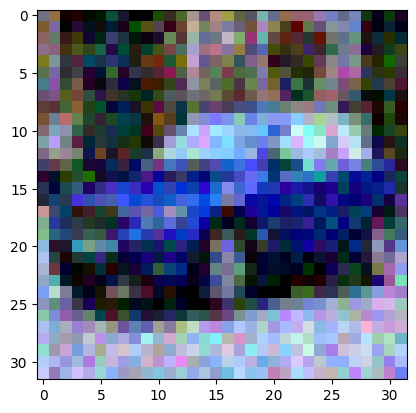

In [6]:
from random import randint
n = randint(0, len(x_train))
x_n = x_train_with_noise[n]
x = x_train[n]
plt.imshow(x_n)


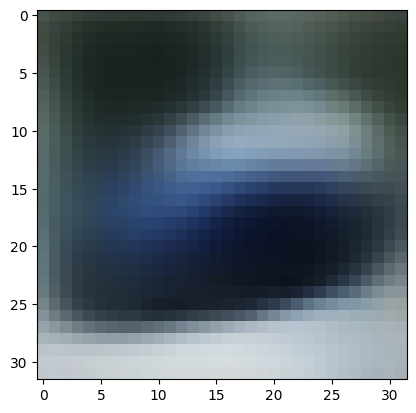

In [8]:

# y = vae.call(tf.expand_dims(x_n, axis=0))
y = vae.call(x_n)
# print(y[0][1])
ans = y[0]
plt.imshow(ans) 

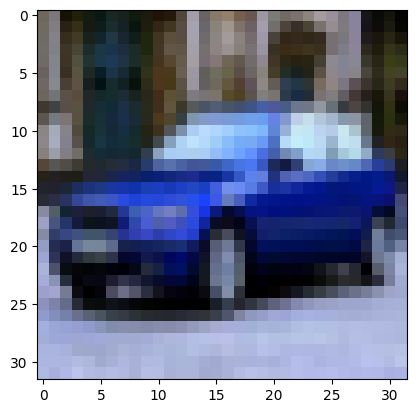

In [9]:
plt.imshow(x)

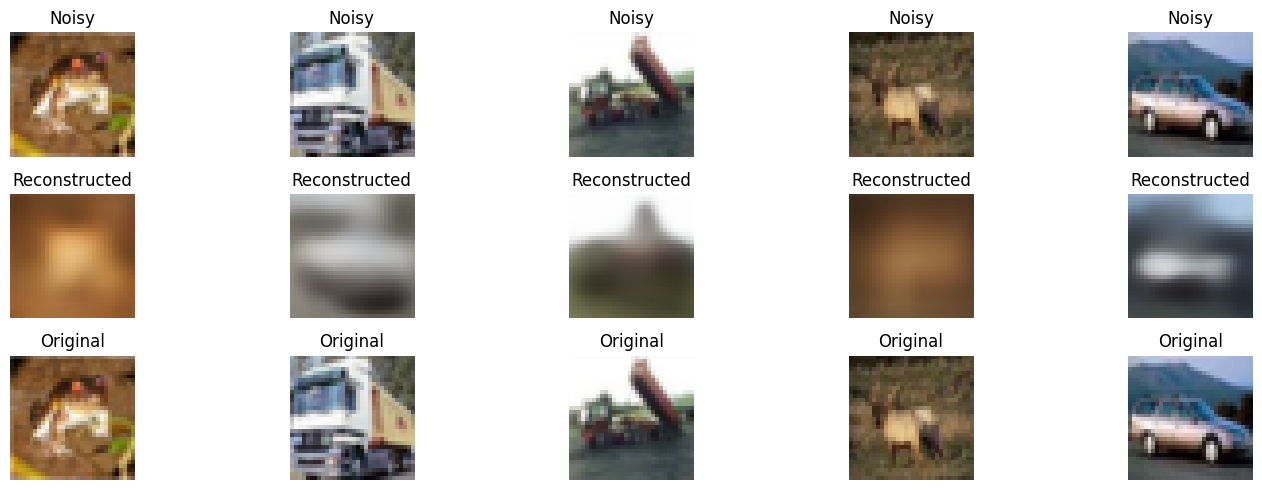

In [11]:
num_examples = 5
test_samples = x_train[:num_examples]

plt.figure(figsize=(15, 5))
for i in range(num_examples):
    # reconstructions = vae.call(tf.expand_dims(test_samples[i], axis=0))[0]
    reconstructions = vae.call(test_samples[i])[0]
    plt.subplot(3, num_examples, i + 1)
    plt.imshow(test_samples[i])
    plt.title("Noisy")
    plt.axis("off")

    plt.subplot(3, num_examples, num_examples + i + 1)
    plt.imshow(reconstructions)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.subplot(3, num_examples, 2*num_examples + i + 1)
    plt.imshow(x_train[i])
    plt.title("Original")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [12]:
class_vectors = [[] for x in range(10)]
for j in range(len(x_train)):
    img = tf.expand_dims(x_train[j], axis=0)
    _, _, z = vae.encoder(img)
    # z = vae.encoder(x_train[j])
    class_vectors[y_train[j][0]].append(z)
    if j%1000 == 0:
      print(j)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


In [13]:
mean_vectors = []
for i in range(10):
  mean_vectors.append(tf.reduce_mean(class_vectors[i], axis = 0))

In [14]:
print(mean_vectors[0])

tf.Tensor(
[[ 0.00094219 -0.02190538 -0.09743104  0.11319382 -0.09135902  0.27610523
   0.71912205  0.01935914 -0.0788128   0.14421096 -0.01024346  0.12347785
  -0.00134257 -0.03907702 -0.10323919 -0.0404098  -0.01099227  0.02246626
  -0.11833719  0.01500421 -0.01207578 -0.0434103   0.01554081  0.32604507
  -0.07050207  0.03104826 -0.50811744  0.0481597  -0.03825335  0.03621954
   0.03199729 -0.04717603]], shape=(1, 32), dtype=float32)


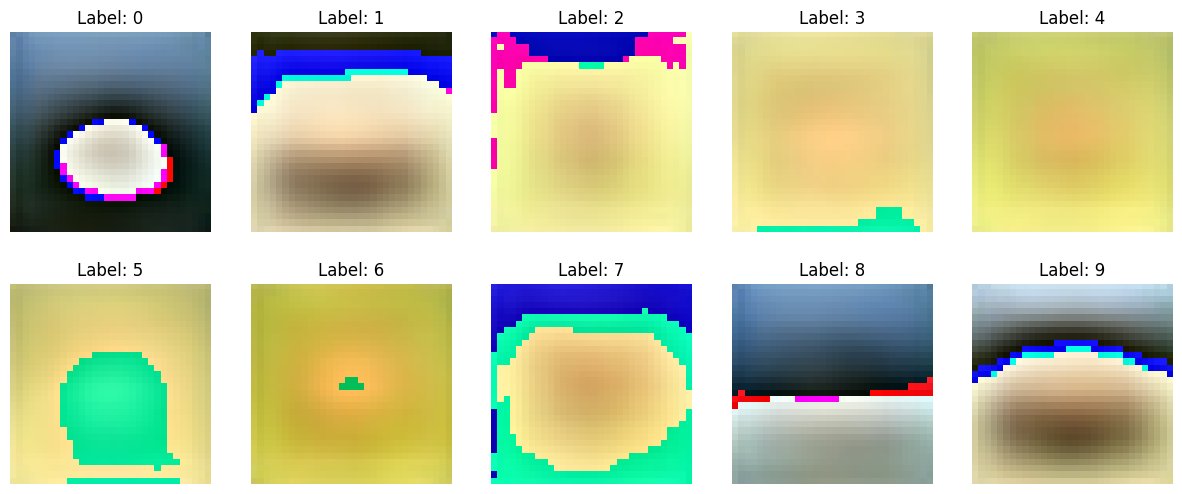

In [15]:
mean_img = []
for i in range(10):
  mean_img.append(vae.decoder(mean_vectors[i]).numpy())

mean_img = np.array(mean_img)
mean_img = (mean_img * 1000).astype(np.uint8)
fig, axes = plt.subplots(2, 5, figsize = (15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(mean_img[i].reshape(32,32,3))
    ax.set_title(f'Label: {i}')
    ax.axis('off')

In [16]:
generated_image = []
generated_label = []
noise_generate_factor = 0.2
for i in range(5):
  for j in range(5000):
    generated_image.append(vae.decoder(mean_vectors[i] + noise_generate_factor * tf.random.normal(shape=mean_vectors[i].shape)))
    generated_label.append(i)
  print(i)

import pickle
import tensorflow as tf

data_to_save = {
    'images': [img.numpy() for img in generated_image], 
    'labels': generated_label 
}


with open('saved_images_with_labels11.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

0
1
2
3
4


In [17]:
generated_image = []
generated_label = []
noise_generate_factor = 0.2
for i in range(5, 10):
  for j in range(5000):
    generated_image.append(vae.decoder(mean_vectors[i] + noise_generate_factor * tf.random.normal(shape=mean_vectors[i].shape)))
    generated_label.append(i)
  print(i)

import pickle
import tensorflow as tf

data_to_save = {
    'images': [img.numpy() for img in generated_image], 
    'labels': generated_label 
}


with open('saved_images_with_labels22.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

5
6
7
8
9


In [ ]:
print(tf.shape(generated_image))
print(type(generated_image))
print(type(generated_image[0]))

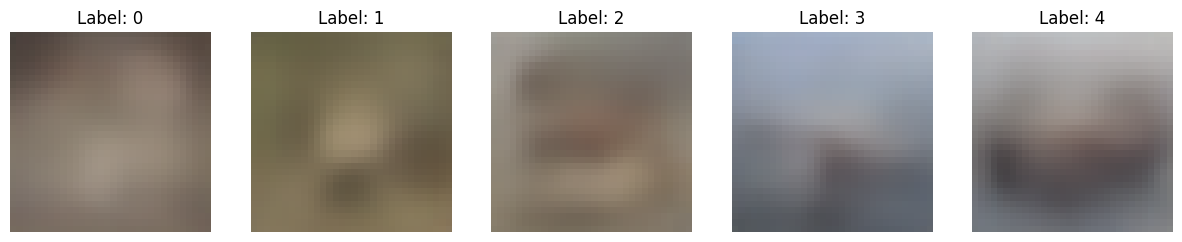

In [23]:
fig, axes = plt.subplots(1, 5, figsize = (15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(generated_image[i * 5000][0])
    ax.set_title(f'Label: {i}')
    ax.axis('off')

In [15]:
import pandas as pd

In [17]:
from sklearn.decomposition import PCA

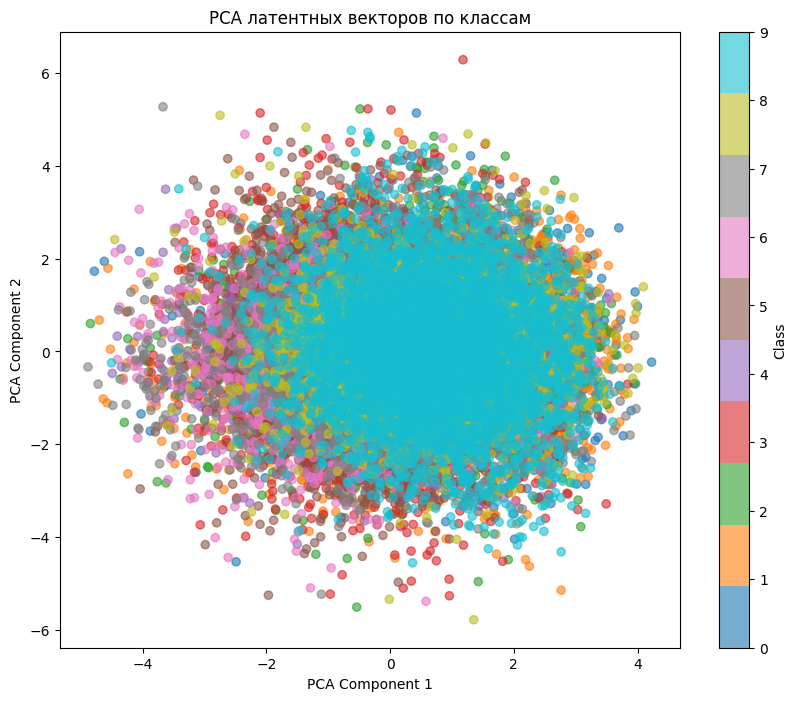

In [20]:
all_z = []
all_labels = []
for i in range(10):
    for z in class_vectors[i]:
        all_z.append(z.numpy().flatten())  # Преобразуем (1, 128) в (128,)
        all_labels.append(i)
all_z = np.array(all_z)  # Теперь форма (N, 128)

# PCA для визуализации
pca = PCA(n_components=2)
z_pca = pca.fit_transform(all_z)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=all_labels, alpha=0.6, cmap='tab10')
plt.colorbar(scatter, label='Class')
plt.title('PCA латентных векторов по классам')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()